In [176]:
import xarray as xr
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload
import cftime
from glob import glob
from typing import List
import warnings
warnings.filterwarnings('ignore')
import matplotlib as mpl
import json
sys.path.append('..')
sys.path.append('../modules')
import constants
import sn_plotting
import open_ds
import signal_to_noise as sn
import xarray_extender as xce
import xarray_class_accessors as xca
import warnings

In [168]:
dir(constants)

['DECK_DIR',
 'IMAGE_SAVE_DIR_INIT',
 'IMAGE_SAVE_DIR_TOP_LEVEL',
 'LONGRUMIP_MODELS_MIN_1850',
 'LONGRUNMIP_CONSECMET_DIR',
 'LONGRUNMIP_DIR',
 'LONGRUNMIP_MODELS',
 'LONGRUNMIP_RETIMED_DIR',
 'LONRUNMIP_LOESS_DIR',
 'MODELS_TO_DROP',
 'MODULE_DIR',
 'PHD_ROOT_DIR',
 'ZECMIP_DIR',
 'ZECMIP_G_DIR',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'os']

In [52]:
constants.ZECMIP_G_DIR

'/g/data/w40/ab2313/PhD/zecmip/regridded'

In [53]:
os.listdir(constants.ZECMIP_G_DIR)

['4xC02', 'picontrol']

In [54]:
os.listdir(os.path.join(constants.ZECMIP_G_DIR, 'picontrol'))

['CanESM5.nc',
 'UKESM1-0-LL.nc',
 'NorESM2-LM.nc',
 'GFDL-ESM4.nc',
 'MPI-ESM1-2-LR.nc',
 'CESM2.nc',
 'MIROC-ES2L.nc',
 'GISS-E2-1-G-CC.nc']

In [55]:
open_kwargs = dict(use_cftime=True, concat_dim='model', combine='nested', 
                  chunks = {'lat': 100, 'lon': 100, 'time': -1})

In [56]:
experiment_ds = xr.open_mfdataset(os.path.join(constants.ZECMIP_G_DIR, '4xC02', '*.nc')).compute()
experiment_ds

<xarray.Dataset>
Dimensions:  (time: 330, model: 8, lat: 96, lon: 192)
Coordinates:
  * time     (time) object 0001-12-31 00:00:00 ... 0330-12-31 00:00:00
  * model    (model) object 'CESM2' 'CanESM5' ... 'NorESM2-LM' 'UKESM1-0-LL'
    height   float64 2.0
  * lat      (lat) float64 -88.57 -86.72 -84.86 -83.0 ... 83.0 84.86 86.72 88.57
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
Data variables:
    tas      (time, model, lat, lon) float32 228.2 228.1 228.0 ... 265.1 265.1

In [57]:
picontrol_ds = xr.open_mfdataset(os.path.join(constants.ZECMIP_G_DIR, 'picontrol', '*.nc'), 
                  use_cftime=True, concat_dim='model', combine='nested').compute()
picontrol_ds

<xarray.Dataset>
Dimensions:  (time: 500, model: 8, lat: 96, lon: 192)
Coordinates:
  * time     (time) object 0001-12-31 00:00:00 ... 0500-12-31 00:00:00
  * model    (model) object 'CESM2' 'CanESM5' ... 'NorESM2-LM' 'UKESM1-0-LL'
    height   float64 2.0
  * lat      (lat) float64 -88.57 -86.72 -84.86 -83.0 ... 83.0 84.86 86.72 88.57
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
Data variables:
    tas      (time, model, lat, lon) float32 225.1 225.0 224.9 ... nan nan nan

# Signal to Noise (latests)

In [104]:
# Control space mean
control_ds_mean = picontrol_ds['tas'].clima.space_mean()
control_ds_mean

<xarray.DataArray 'tas' (time: 500, model: 8)>
array([[287.04172954, 284.93304252, 285.0284936 , ..., 286.51081111,
        286.18641824, 284.82300349],
       [287.22693566, 284.92986377, 285.03701229, ..., 286.69564505,
        286.23123655, 284.89221269],
       [287.0689092 , 284.83803731, 285.04571431, ..., 286.84364449,
        286.12457087, 284.88384159],
       ...,
       [287.17957431, 284.84417823, 285.34408308, ..., 286.82962437,
                 nan,          nan],
       [287.16574524, 284.87533132, 285.26315884, ..., 286.78953964,
                 nan,          nan],
       [287.2234347 , 284.89745821, 285.32010857, ..., 286.6793418 ,
                 nan,          nan]])
Coordinates:
  * time     (time) object 0001-12-31 00:00:00 ... 0500-12-31 00:00:00
  * model    (model) object 'CESM2' 'CanESM5' ... 'NorESM2-LM' 'UKESM1-0-LL'
    height   float64 2.0

In [111]:
# Only 150 years shared between all dataaset
experiment_ds = experiment_ds.isel(time=slice(0, 150))

In [112]:
# Calculating the anomalies
experiment_anom_ds = experiment_ds.clima_ds.anomalies(picontrol_ds)
# Space mean of anomalies
experiment_smean_ds = experiment_anom_ds.clima_ds.space_mean()
experiment_smean_ds = experiment_smean_ds.compute()
experiment_smean_ds

tas, Using historical dataset


<xarray.Dataset>
Dimensions:  (time: 150, model: 8)
Coordinates:
  * time     (time) object 0001-12-31 00:00:00 ... 0150-12-31 00:00:00
  * model    (model) object 'CESM2' 'CanESM5' ... 'NorESM2-LM' 'UKESM1-0-LL'
    height   float64 2.0
Data variables:
    tas      (time, model) float64 1.846 1.937 1.339 2.397 ... 1.26 nan 2.924

In [114]:
RUN_PARAMS = dict( start_window = 3, end_window = 61, step_window = 2)
RUN_PARAMS

{'start_window': 3, 'end_window': 61, 'step_window': 2}

In [117]:
# This is for all models at once.
unstable_sn_da , stable_sn_da = experiment_smean_ds.tas.sn.sn_multiwindow(control_ds_mean, **RUN_PARAMS)

Starting window loop from 3 to 61 with step size of 2
3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 

In [153]:
# Extracting the increasing and decreasing singal to noise trends in
unstable_increaseing_sn_da = unstable_sn_da[['signal_to_noise']].where(unstable_sn_da[['signal_to_noise']] > 0)
unstable_decreaseing_sn_da = unstable_sn_da[['signal_to_noise']].where(unstable_sn_da[['signal_to_noise']] < 0)

In [159]:
unstable_increaseing_sn_number = unstable_increaseing_sn_da.count(dim='model')
unstable_decreaseing_sn_number = unstable_decreaseing_sn_da.count(dim='model')

unstable_increaseing_sn_number

<xarray.Dataset>
Dimensions:          (window: 29, time: 98)
Coordinates:
  * time             (time) int64 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98
    height           float64 2.0
  * window           (window) int64 3 5 7 9 11 13 15 17 ... 47 49 51 53 55 57 59
Data variables:
    signal_to_noise  (window, time) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0

In [274]:
# Chaging the model dimensino from a coordinate to a data variable. This is done as most functions are 
# set up this way
experiment_smean_ds_dvar = xce.convert_dimension_to_data_vars(experiment_smean_ds.tas, dim='model')
experiment_smean_ds_dvar

<xarray.Dataset>
Dimensions:         (time: 150)
Coordinates:
  * time            (time) object 0001-12-31 00:00:00 ... 0150-12-31 00:00:00
    model           <U5 'CESM2'
    height          float64 2.0
Data variables:
    CESM2           (time) float64 1.846 1.997 1.995 1.799 ... 1.872 1.986 1.696
    CanESM5         (time) float64 1.937 2.008 2.094 2.04 ... nan nan nan nan
    GFDL-ESM4       (time) float64 1.339 1.407 1.5 1.418 ... 1.229 1.207 1.241
    GISS-E2-1-G-CC  (time) float64 2.397 2.338 2.085 2.068 ... 2.427 2.472 2.139
    MIROC-ES2L      (time) float64 1.3 1.408 1.601 1.648 ... 1.179 0.9098 0.8843
    MPI-ESM1-2-LR   (time) float64 1.475 1.543 1.621 1.515 ... 1.28 1.324 1.26
    NorESM2-LM      (time) float64 1.408 1.222 1.192 1.529 ... nan nan nan nan
    UKESM1-0-LL     (time) float64 2.681 2.827 2.819 2.842 ... 2.888 2.884 2.924

# Plots

In [160]:
unstable_sn_da

<xarray.Dataset>
Dimensions:          (window: 29, time: 98, model: 8)
Coordinates:
  * time             (time) int64 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98
  * model            (model) object 'CESM2' 'CanESM5' ... 'UKESM1-0-LL'
    height           float64 2.0
  * window           (window) int64 3 5 7 9 11 13 15 17 ... 47 49 51 53 55 57 59
Data variables:
    signal_to_noise  (window, time, model) float64 nan nan nan ... nan nan nan
    lower_bound      (window, model) float64 -7.346 -7.683 ... -2.387 -3.455
    upper_bound      (window, model) float64 7.627 7.667 7.668 ... 5.151 5.735

In [282]:
unstable_sn_da.max().signal_to_noise

<xarray.DataArray 'signal_to_noise' ()>
array(4.25858723)
Coordinates:
    height   float64 2.0

CESM2
{'height': 15, 'width': 7, 'hspace': 0.3, 'vmin': -4.5, 'vmax': 4.5, 'step': 0.5, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x7fdb581e2c40>, 'line_color': 'limegreen', 'line_alpha': 0.5, 'cbar_label': 'S/N', 'cbartick_offset': 0, 'title': 'CESM2', 'label_size': 12, 'extend': 'both', 'xlowerlim': None, 'xupperlim': None, 'filter_max': False, 'levels': array([-4.5, -4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,
        1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5]), 'cbar_xticklabels': array([-4.5, -4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,
        1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5]), 'cbar_ticks': array([-4.5, -4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,
        1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5])}


['tas']
0 Saving /home/563/ab2313/gdata/images/PhD/init/zecmip_05_individual_models_CESM2_SN_multi_window.png
CanESM5
{'height': 15, 'width': 7, 'hspace': 0.3, 'vmin': -4.5, 'vmax': 4.5, 'step': 0

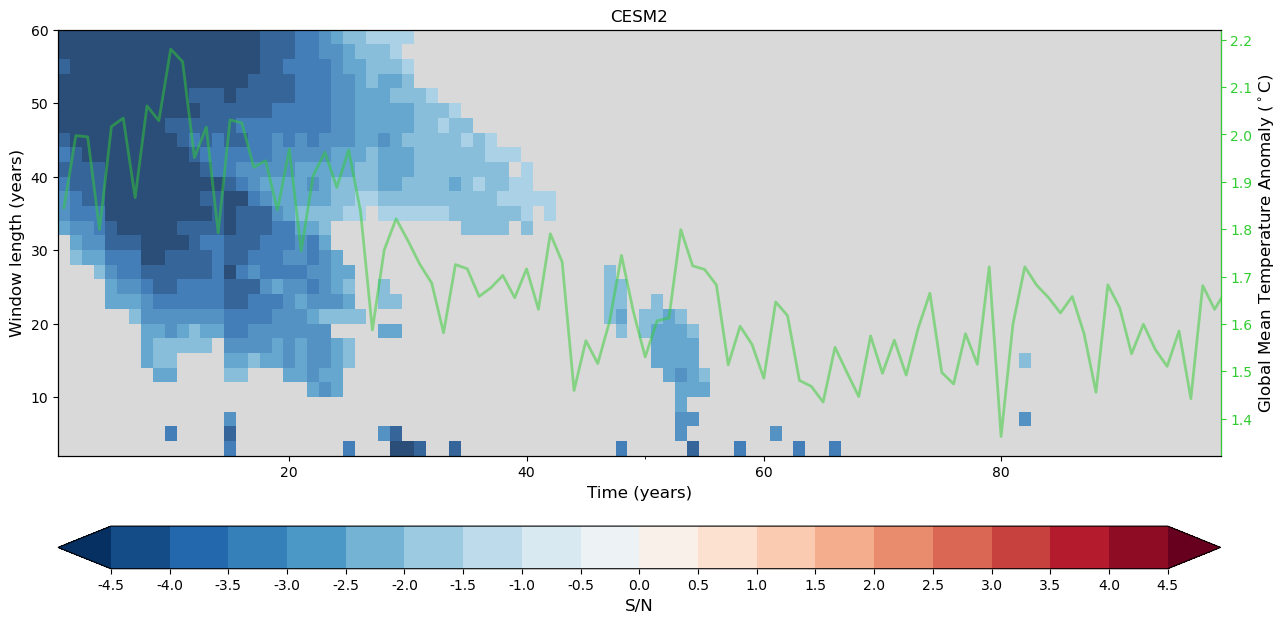

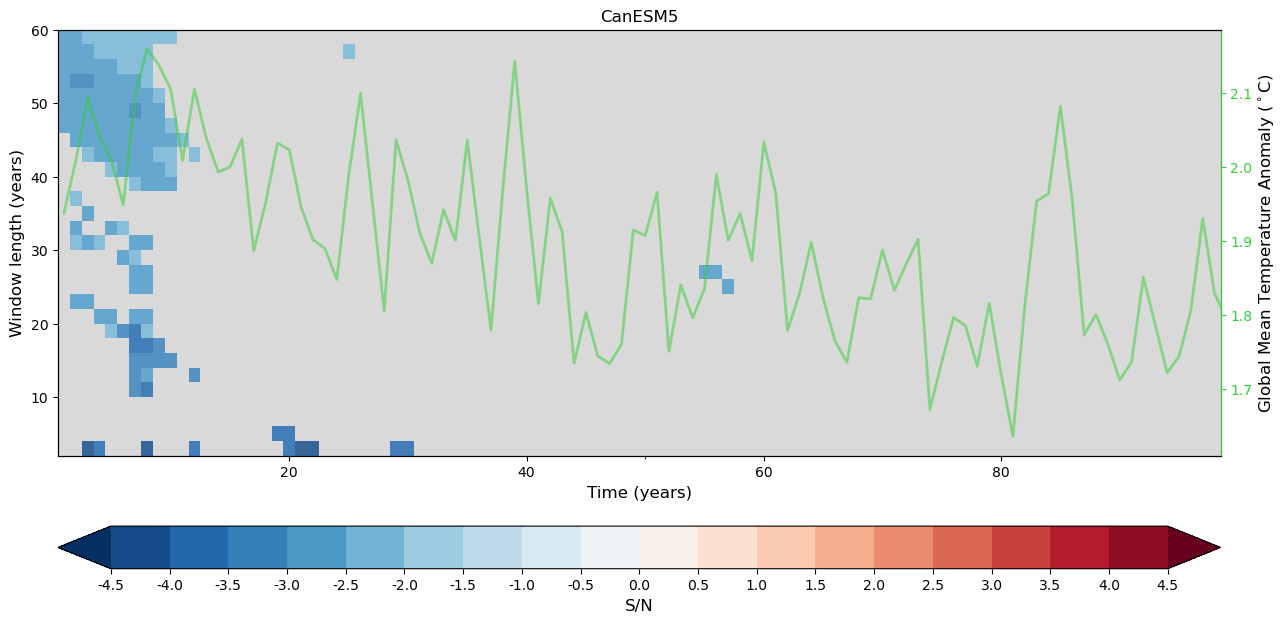

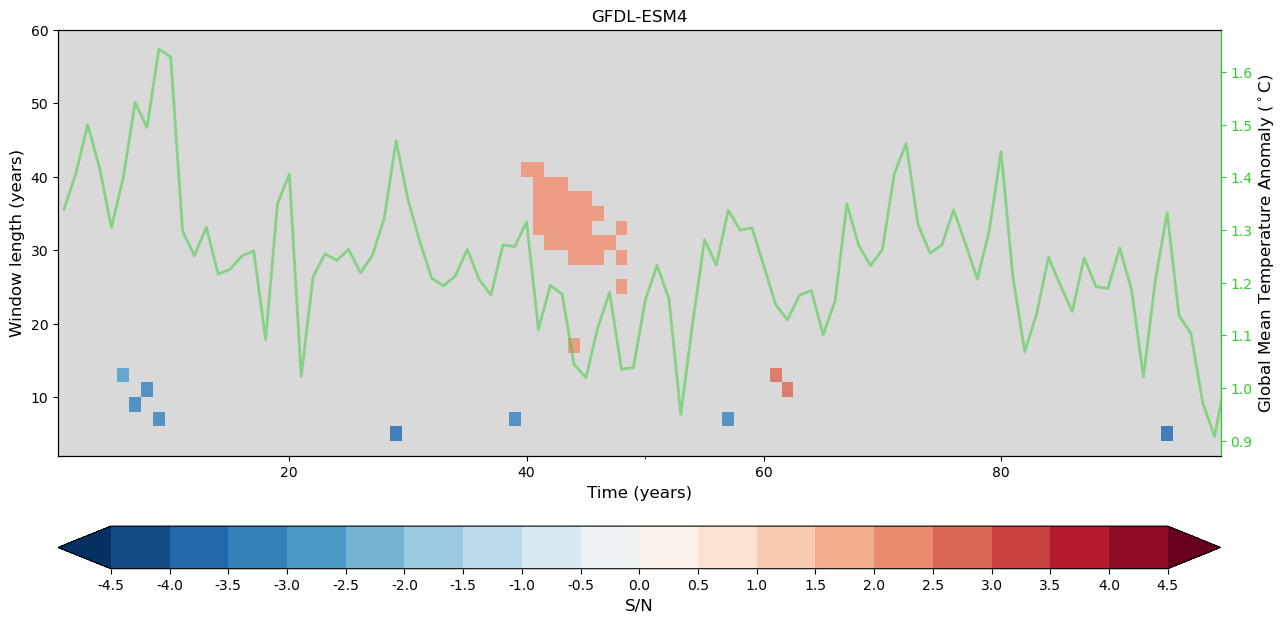

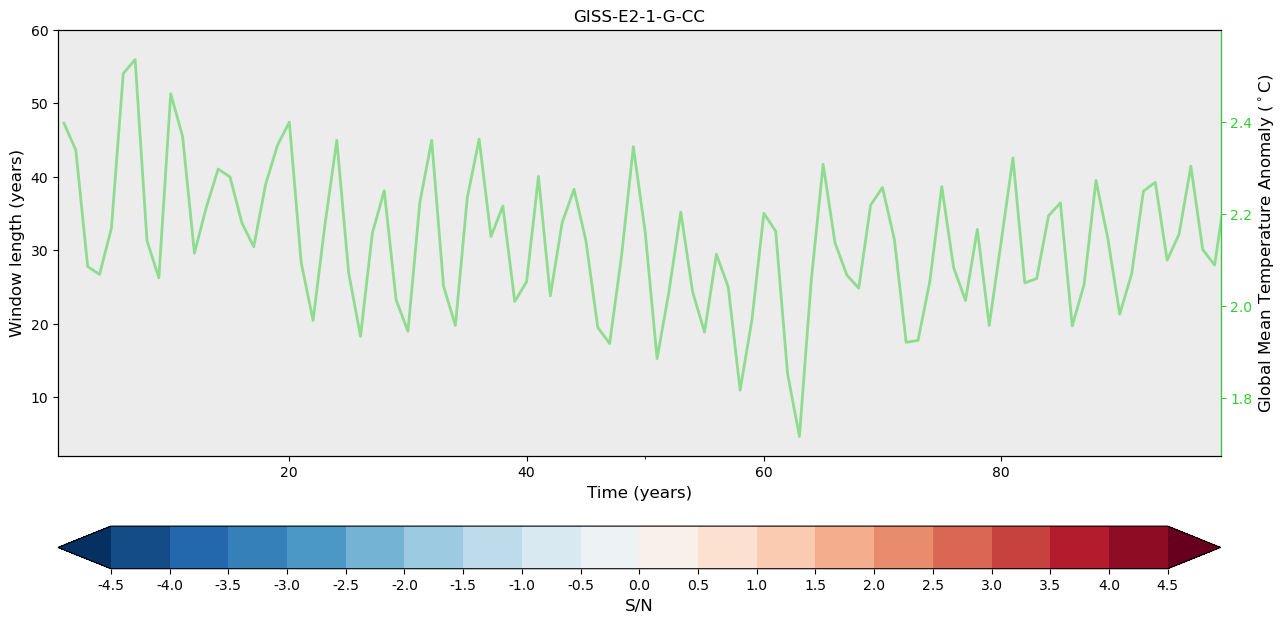

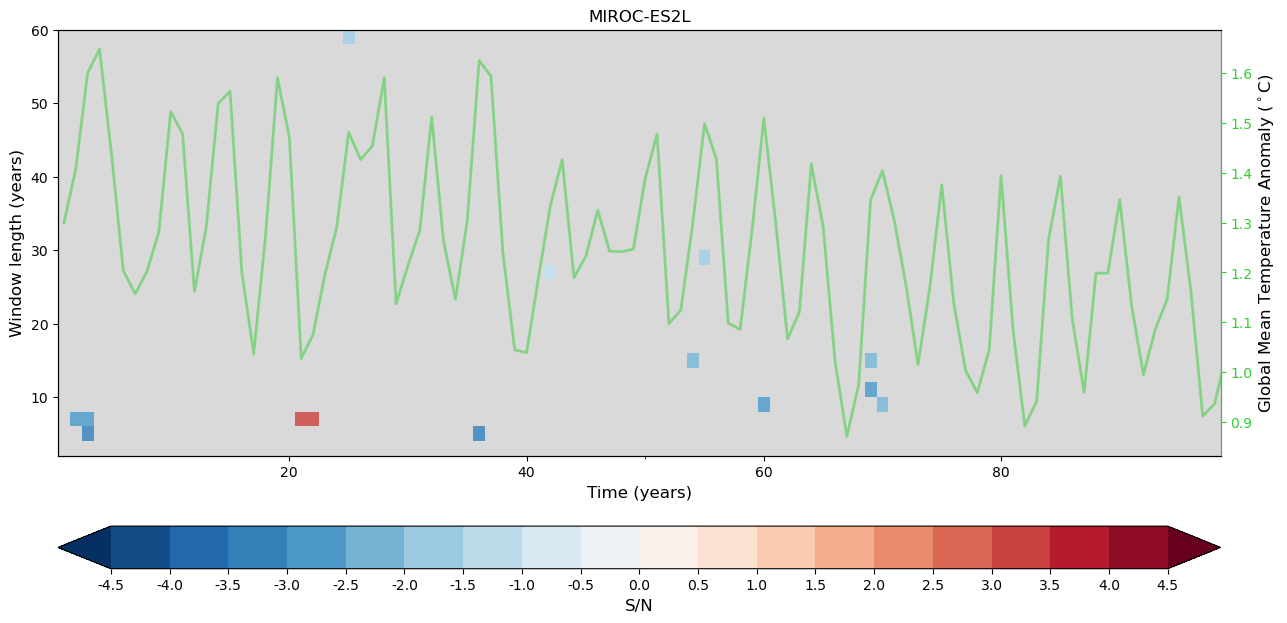

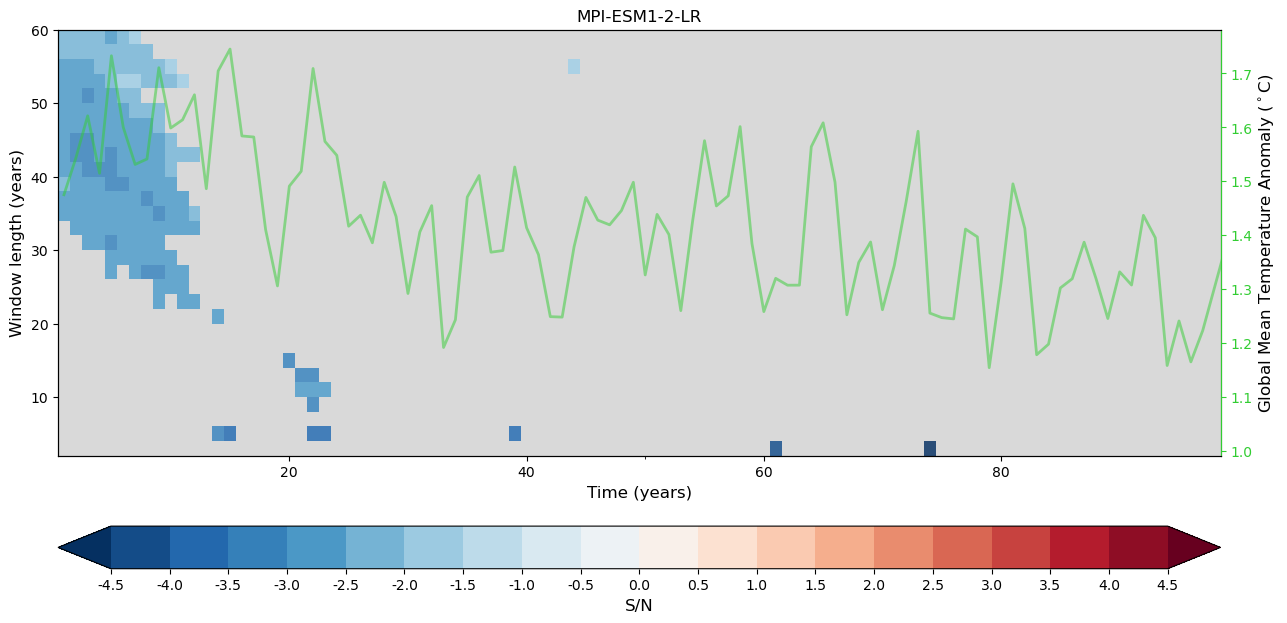

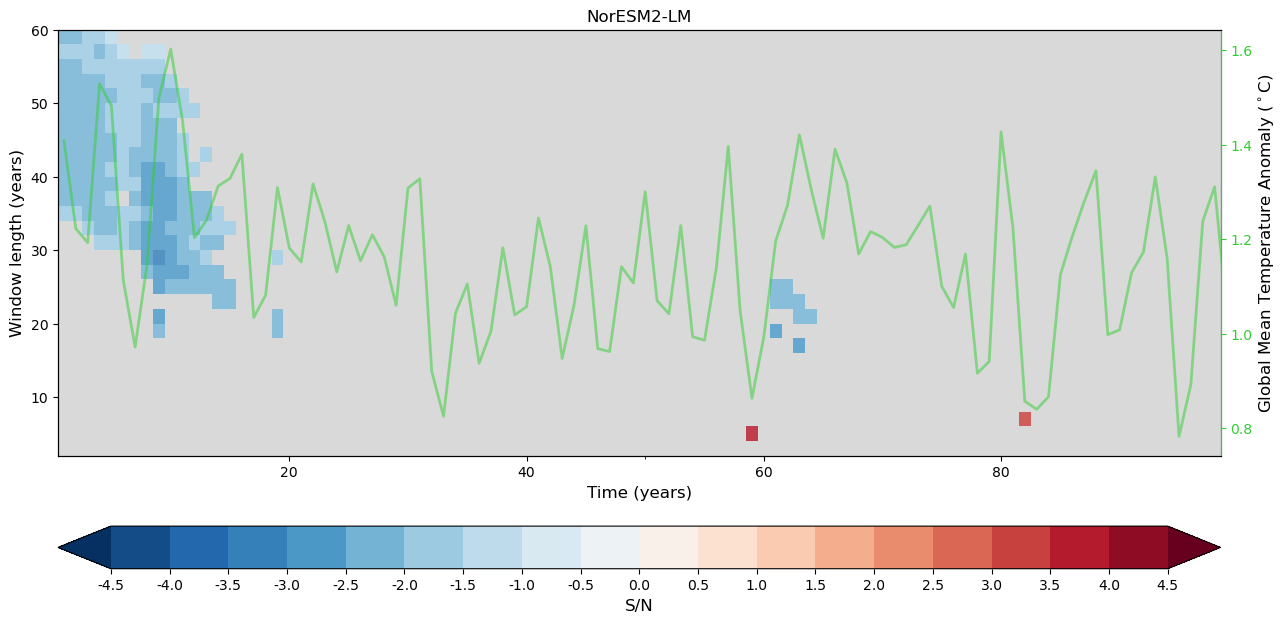

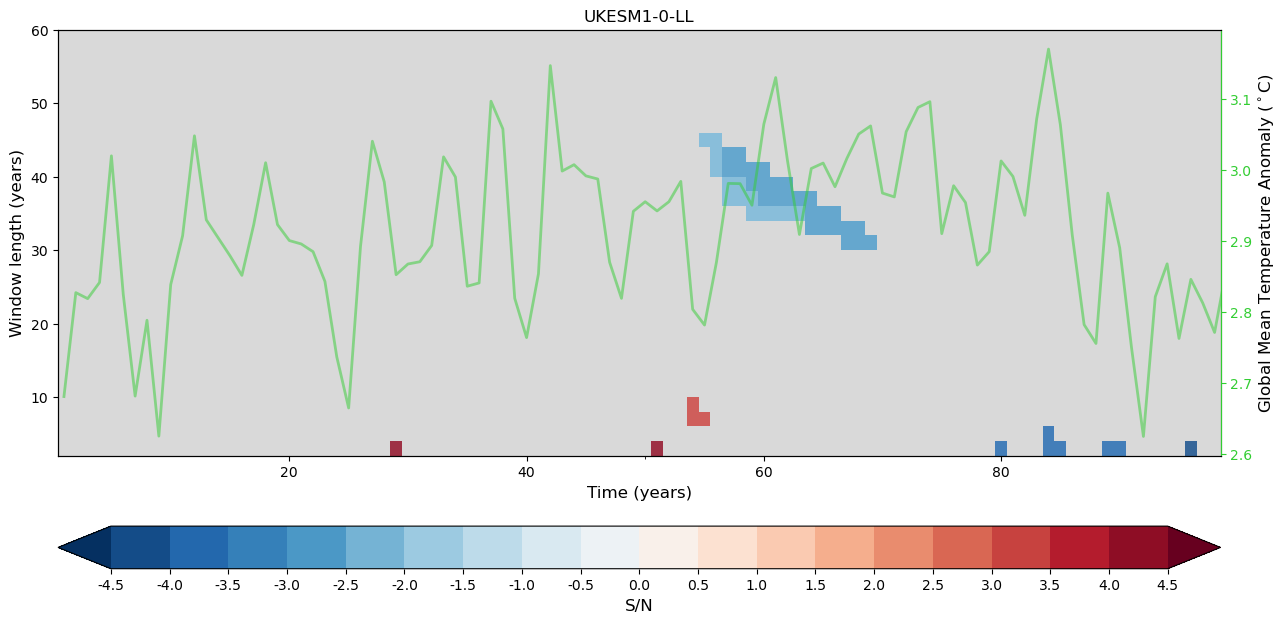

In [286]:
reload(sn_plotting)
mpl.rcParams.update(mpl.rcParamsDefault)

# Looping through all the models in our resultant dicionary and printing the result. 
for model in unstable_sn_da.model.values:
    print(model)
    (fig, ax1, ax2, ax3, cbar) = sn_plotting.sn_multi_window_in_time(
                            unstable_sn_da.sel(model=model)['signal_to_noise'], 
                            stable_sn_da.sel(model=model)['signal_to_noise'],
                            experiment_smean_ds.sel(model=model).dropna(dim='time'),
                                title=model, step=0.5, vmax=4.5, vmin=-4.5);
    
    save_name = f'{constants.IMAGE_SAVE_DIR_INIT}/zecmip_05_individual_models_{model}_SN_multi_window.png'
    print(f'Saving {save_name}')
    fig.savefig(save_name, dpi=400, bbox_inches='tight')

In [191]:
len(stable_sn_da.model.values)

8

{'height': 15, 'width': 12, 'hspace': 0.3, 'vmin': 0, 'vmax': 9, 'step': 1, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x7fdb0ad723a0>, 'line_color': 'limegreen', 'line_alpha': 0.5, 'cbar_label': 'Number of Unstable Models', 'cbartick_offset': 0.5, 'title': 'Fraction of ZECMIP Models with Decreasing GMST Trends', 'label_size': 12, 'extend': 'neither', 'xlowerlim': None, 'xupperlim': 100, 'hieght': 15, 'cbar_ncols': 5, 'filter_max': True, 'levels': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), 'cbar_xticklabels': array([0, 1, 2, 3, 4, 5, 6, 7, 8]), 'cbar_ticks': array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5])}


locator: <matplotlib.ticker.FixedLocator object at 0x7fdb39affd00>
cbar x-tick labels = [0 1 2 3 4 5 6 7 8]
['CESM2', 'CanESM5', 'GFDL-ESM4', 'GISS-E2-1-G-CC', 'MIROC-ES2L', 'MPI-ESM1-2-LR', 'NorESM2-LM', 'UKESM1-0-LL']
0 1 2 3 4 5 6 7 Saving /home/563/ab2313/gdata/images/PhD/init/zecmip_05_all_models_fraction_decrasing_unstable_SN_multi_window.png


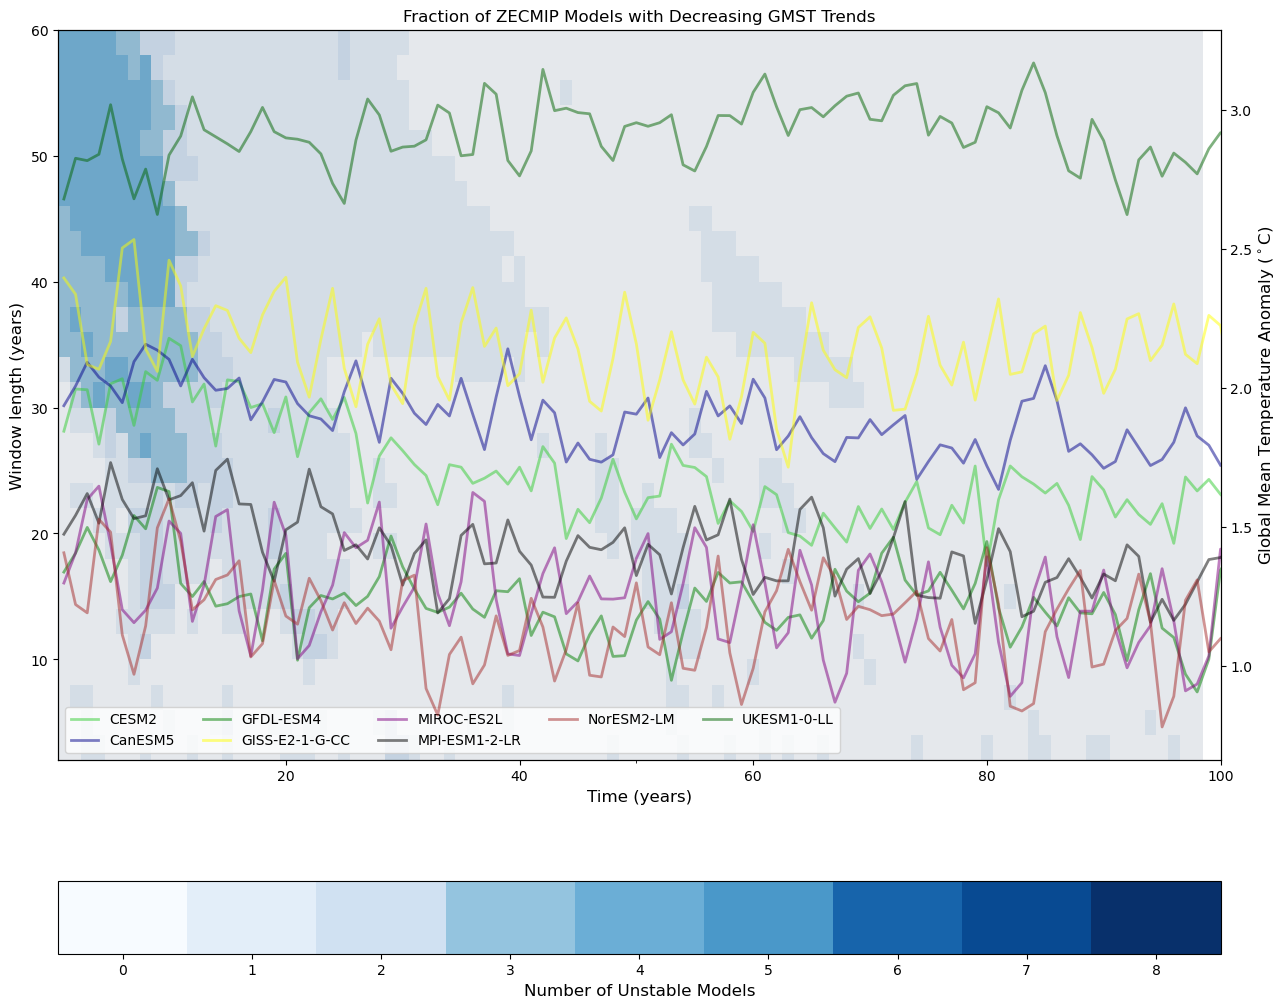

In [288]:
mpl.rcParams.update(mpl.rcParamsDefault)
fig, ax1, ax2, ax3,cbar = sn_plotting.sn_multi_window_in_time(
    unstable_decreaseing_sn_number.signal_to_noise,
    stable_sn_da.signal_to_noise.count(dim='model'), 
    experiment_smean_ds_dvar, 
    logginglevel='DEBUG', 
    hieght = 15, width = 12,
    vmin=0, vmax=9, step=1, cbartick_offset = 0.5,
    cmap='Blues',
    extend='neither', xupperlim = 100,
    cbar_label= 'Number of Unstable Models', 
    title = f'Fraction of ZECMIP Models with Decreasing GMST Trends', cbar_ncols = 5, filter_max=True)


save_name = f'{constants.IMAGE_SAVE_DIR_INIT}/zecmip_05_all_models_fraction_decrasing_unstable_SN_multi_window.png'
print(f'Saving {save_name}')
fig.savefig(save_name, dpi=400, bbox_inches='tight')

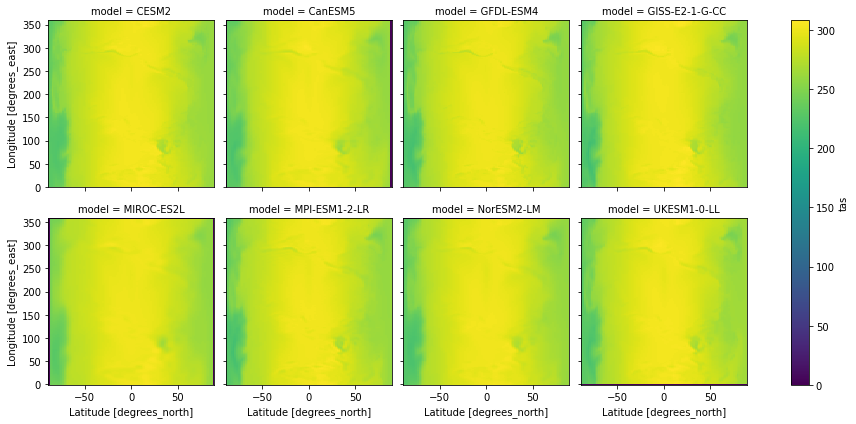

In [10]:
experiment_ds.tas.isel(time=5).plot.pcolormesh('lat', 'lon', col='model', col_wrap=4)

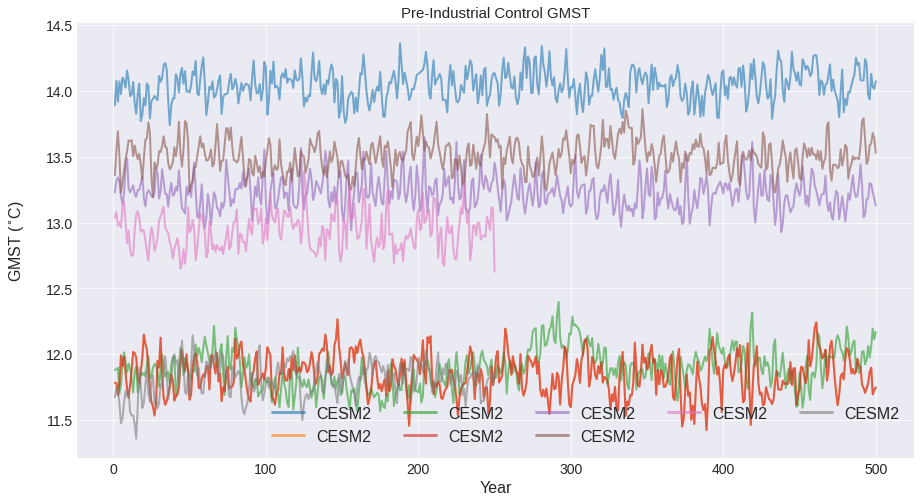

In [22]:

plt.style.use('seaborn-darkgrid')
fig, ax = plt.subplots(figsize=(15,8))

time = control_ds_mean['time'].values
years = [t.year for t in time]
for model in list(control_ds_mean.model.values):

    plot_kwargs = dict(alpha = 0.6,linewidth = 2)
        
    ax.plot(years, control_ds_mean.sel(model=model).values - 273.15, label=var, **plot_kwargs)
    
ax.set_ylabel(r'GMST ($^{\circ}$C)', size=16, labelpad=20)
ax.set_xlabel('Year', size=16)
# ax.set_xlim(years[0], years[500])
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)
leg = ax.legend(ncol = 5, fontsize=16)
[line.set_linewidth(3) for line in leg.get_lines()];
ax.set_title('Pre-Industrial Control GMST', fontsize=15);

# fig.savefig(os.path.join(IMG_DIR, '04_multi_model_control_good_models_t500_year_axis.png'), bbox_inch

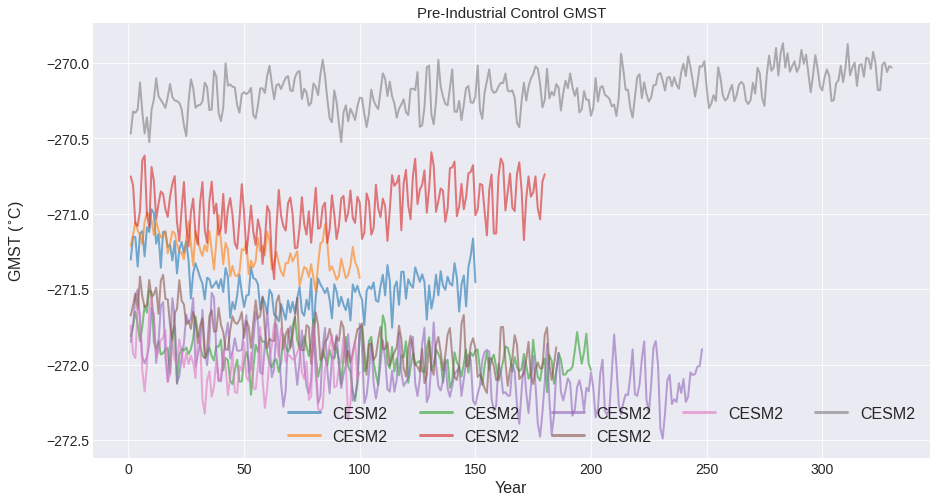

In [33]:

plt.style.use('seaborn-darkgrid')
fig, ax = plt.subplots(figsize=(15,8))

time = experiment_smean_ds['time'].values
years = [t.year for t in time]
for model in list(experiment_smean_ds.model.values):

    plot_kwargs = dict(alpha = 0.6,linewidth = 2)
        
    ax.plot(years, experiment_smean_ds.sel(model=model).tas.values - 273.15, label=var, **plot_kwargs)
    
ax.set_ylabel(r'GMST ($^{\circ}$C)', size=16, labelpad=20)
ax.set_xlabel('Year', size=16)
# ax.set_xlim(years[0], years[500])
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)
leg = ax.legend(ncol = 5, fontsize=16)
[line.set_linewidth(3) for line in leg.get_lines()];
ax.set_title('Pre-Industrial Control GMST', fontsize=15);

# fig.savefig(os.path.join(IMG_DIR, '04_multi_model_control_good_models_t500_year_axis.png'), bbox_inch